# Q1. What is the price distribution of menu items?

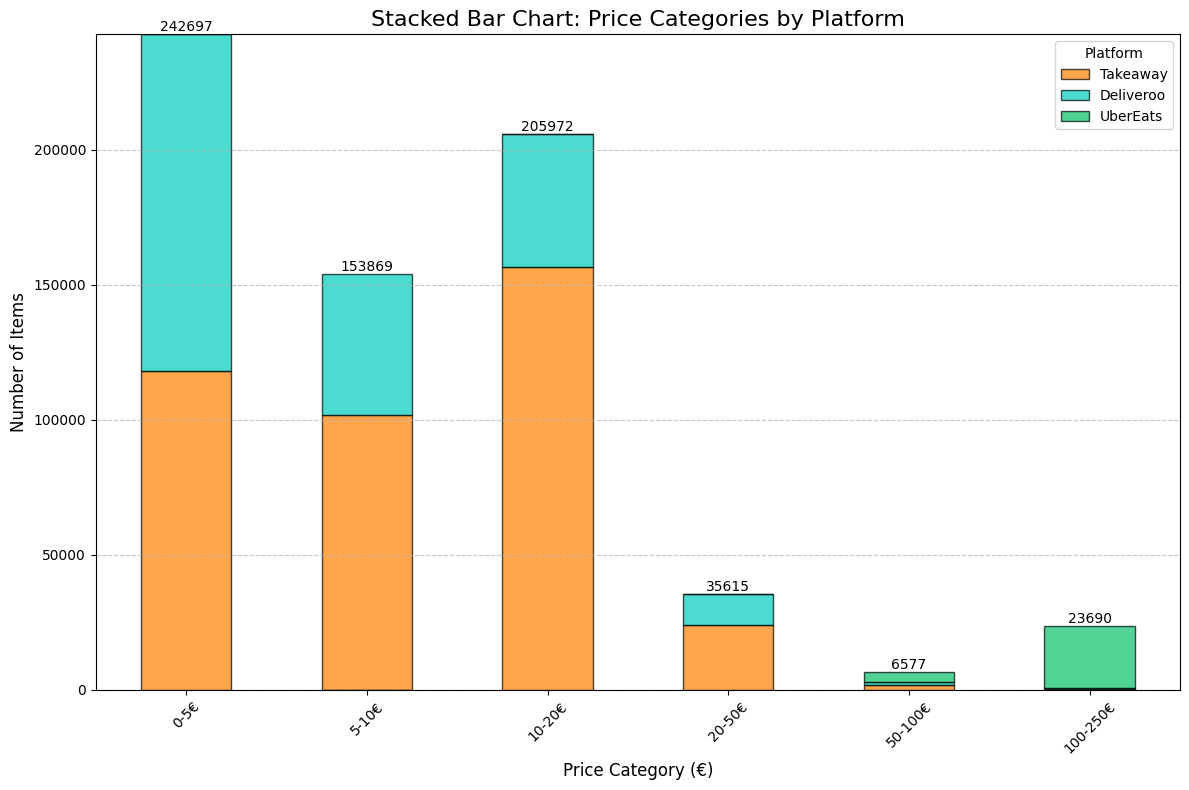

In [11]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Your database paths (use your real paths here)
databases = {
    "Takeaway":  r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\takeaway.db",
    "Deliveroo": r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\deliveroo.db",
    "UberEats":  r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\ubereats.db",
}

def fetch_prices(db_path, table_name="menuItems", price_column="price"):
    # Fetch prices as floats from a specific table/column
    try:
        with sqlite3.connect(db_path) as conn:
            cursor = conn.cursor()
            query = f"""
                SELECT {price_column}
                FROM {table_name}
                WHERE {price_column} IS NOT NULL
                  AND TRIM({price_column}) <> ''
                  AND CAST({price_column} AS REAL) > 0;
            """
            cursor.execute(query)
            prices = [float(row[0]) for row in cursor.fetchall()]
        return prices
    except Exception as e:
        print(f"Error fetching data from {db_path}: {e}")
        return []

# Fetch prices for each platform (adjust table names if needed)
filtered_takeaway_prices  = fetch_prices(databases["Takeaway"],  "menuItems",  "price")
filtered_deliveroo_prices = fetch_prices(databases["Deliveroo"], "menu_items", "price")
filtered_ubereats_prices  = fetch_prices(databases["UberEats"],  "menu_items", "price")

# Define price bins
bins = [0, 5, 10, 20, 50, 100, 250]
labels = ['0-5€', '5-10€', '10-20€', '20-50€', '50-100€', '100-250€']

# Bin prices
takeaway_binned  = pd.cut(filtered_takeaway_prices,  bins=bins, labels=labels, right=False)
deliveroo_binned = pd.cut(filtered_deliveroo_prices, bins=bins, labels=labels, right=False)
ubereats_binned  = pd.cut(filtered_ubereats_prices,  bins=bins, labels=labels, right=False)

# Count bins 
takeaway_counts  = takeaway_binned.value_counts().reindex(labels, fill_value=0)
deliveroo_counts = deliveroo_binned.value_counts().reindex(labels, fill_value=0)
ubereats_counts  = ubereats_binned.value_counts().reindex(labels, fill_value=0)

# Combine into one DataFrame
bar_data = pd.DataFrame({
    "Price Category": labels,
    "Takeaway": takeaway_counts.values,
    "Deliveroo": deliveroo_counts.values,
    "UberEats": ubereats_counts.values
})

# Plot stacked bars (use the returned Axes for correct annotation placement)
ax = bar_data.set_index("Price Category").plot(
    kind="bar",
    stacked=True,
    color=["#FF8000", "#00CCBC", "#06C167"],  # Takeaway, Deliveroo, UberEats
    edgecolor="black",
    alpha=0.7,
    figsize=(12, 8),
)
ax.set_title("Stacked Bar Chart: Price Categories by Platform", fontsize=16)
ax.set_xlabel("Price Category (€)", fontsize=12)
ax.set_ylabel("Number of Items", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
ax.legend(title="Platform", fontsize=10)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Add totals on top of each stacked bar
totals = bar_data[["Takeaway", "Deliveroo", "UberEats"]].sum(axis=1).values
for i, total in enumerate(totals):
    ax.text(i, total, str(int(total)), ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()


# Q2.  What is the distribution of restaurants per location?

In [13]:
import pandas as pd
import folium
from folium.plugins import HeatMap
import webbrowser
from pathlib import Path

def q(con, sql, params=None):
    return pd.read_sql_query(sql, con, params=params)

# Restaurants per location (Takeaway)
df_ta = q(conn, """
SELECT
  l.ID AS location_id,
  l.city,
  l.postalCode,
  l.latitude,
  l.longitude,
  COUNT(DISTINCT lr.restaurant_id) AS restaurants
FROM ta.locations l
JOIN ta.locations_to_restaurants lr
  ON lr.location_id = l.ID
WHERE l.latitude IS NOT NULL AND l.longitude IS NOT NULL
GROUP BY l.ID, l.city, l.postalCode, l.latitude, l.longitude;
""")

# HeatMap expects [lat, lon, weight]
heat_data = df_ta[["latitude", "longitude", "restaurants"]].values.tolist()

m = folium.Map(location=[50.8503, 4.3517], zoom_start=8)
HeatMap(heat_data, radius=18, blur=15, min_opacity=0.3).add_to(m)

out_path = Path(r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\heatmap_takeaway_restaurants_per_location.html").resolve()
m.save(str(out_path))
webbrowser.open(str(out_path))
print("Saved to:", out_path)


Saved to: C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\heatmap_takeaway_restaurants_per_location.html


# ubereats heat map of restuarant location

In [33]:
import sqlite3
import pandas as pd
import folium
from folium.plugins import HeatMap
import webbrowser
from pathlib import Path

TAKEAWAY_DB  = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\takeaway.db"
UBEREATS_DB  = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\ubereats.db"
DELIVEROO_DB = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\deliveroo.db"

def q(con, sql, params=None):
    return pd.read_sql_query(sql, con, params=params)

# Recreate connection 
conn = sqlite3.connect(DELIVEROO_DB)
conn.execute(f"ATTACH DATABASE '{UBEREATS_DB}' AS ue;")

# ----- Deliveroo heatmap (restaurants table in main) -----
df_deliveroo = q(conn, """
SELECT latitude, longitude
FROM restaurants
WHERE latitude IS NOT NULL AND longitude IS NOT NULL;
""")

m = folium.Map(location=[50.8503, 4.3517], zoom_start=8)
HeatMap(df_deliveroo[["latitude", "longitude"]].values.tolist(), radius=18, blur=15, min_opacity=0.3).add_to(m)

out_del = Path(r"C:\Users\welde\Desktop\heatmap_deliveroo_restaurants.html")
m.save(str(out_del))
webbrowser.open(str(out_del))
print("Saved Deliveroo map to:", out_del)



df_ubereats = q(conn, """
SELECT latitude, longitude
FROM "ue"."locations"
WHERE latitude IS NOT NULL AND longitude IS NOT NULL;
""")

m = folium.Map(location=[50.8503, 4.3517], zoom_start=8)
HeatMap(df_ubereats[["latitude", "longitude"]].values.tolist(), radius=18, blur=15, min_opacity=0.3).add_to(m)

out_ue = Path(r"C:\Users\welde\Desktop\heatmap_ubereats_restaurants.html")
m.save(str(out_ue))
webbrowser.open(str(out_ue))
print("Saved UberEats map to:", out_ue)


Saved Deliveroo map to: C:\Users\welde\Desktop\heatmap_deliveroo_restaurants.html
Saved UberEats map to: C:\Users\welde\Desktop\heatmap_ubereats_restaurants.html


In [27]:
q(conn, "PRAGMA .table_info(locations);")

,cid,name,type,notnull,dflt_value,pk
0,0,id,INTEGER,1,None,0
1,1,name,TEXT,1,None,0
2,2,region,TEXT,1,None,0
3,3,latitude,double precision,1,None,0
4,4,longitude,double precision,1,None,0
5,5,visited_time,timestamp with time zone,0,None,0


In [ ]:

TAKEAWAY_DB  = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\takeaway.db"
UBEREATS_DB  = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\ubereats.db"
DELIVEROO_DB = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\deliveroo.db"

def q(con, sql, params=None):
    return pd.read_sql_query(sql, con, params=params)

conn = sqlite3.connect(DELIVEROO_DB)
conn.execute(f"ATTACH DATABASE '{TAKEAWAY_DB}' AS ta;")
conn.execute(f"ATTACH DATABASE '{UBEREATS_DB}' AS ue;")

df_del = q(conn, """
SELECT latitude, longitude
FROM restaurants
WHERE latitude IS NOT NULL AND longitude IS NOT NULL;
""")

df_ta = q(conn, """
SELECT
  l.latitude,
  l.longitude,
  COUNT(DISTINCT lr.restaurant_id) AS restaurants
FROM ta.locations l
JOIN ta.locations_to_restaurants lr ON lr.location_id = l.ID
WHERE l.latitude IS NOT NULL AND l.longitude IS NOT NULL
GROUP BY l.latitude, l.longitude;
""")

df_ue = q(conn, """
SELECT latitude, longitude
FROM ue.locations
WHERE latitude IS NOT NULL AND longitude IS NOT NULL;
""")

# Different color gradients per platform
grad_deliveroo = {0.2: "#b2f5ea", 0.5: "#00ccbc", 0.8: "#006d66"}  # teal
grad_takeaway  = {0.2: "#ffe0b2", 0.5: "#ff8000", 0.8: "#8a3d00"}  # orange
grad_ubereats  = {0.2: "#c8f7d0", 0.5: "#06c167", 0.8: "#014d2a"}  # green

m = folium.Map(location=[50.8503, 4.3517], zoom_start=8)

fg_del = folium.FeatureGroup(name="Deliveroo (restaurants)", show=True)
HeatMap(
    df_del[["latitude", "longitude"]].values.tolist(),
    radius=18, blur=15, min_opacity=0.3,
    gradient=grad_deliveroo
).add_to(fg_del)
fg_del.add_to(m)

fg_ta = folium.FeatureGroup(name="Takeaway (restaurants per location)", show=False)
HeatMap(
    df_ta[["latitude", "longitude", "restaurants"]].values.tolist(),
    radius=18, blur=15, min_opacity=0.3,
    gradient=grad_takeaway
).add_to(fg_ta)
fg_ta.add_to(m)

fg_ue = folium.FeatureGroup(name="UberEats (locations)", show=False)
HeatMap(
    df_ue[["latitude", "longitude"]].values.tolist(),
    radius=18, blur=15, min_opacity=0.3,
    gradient=grad_ubereats
).add_to(fg_ue)
fg_ue.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

out_path = Path(r"C:\Users\welde\Desktop\heatmap_toggle_all_platforms.html")
m.save(str(out_path))
webbrowser.open(str(out_path))
print("Saved to:", out_path)


Saved to: C:\Users\welde\Desktop\heatmap_toggle_all_platforms.html


# Where are the delivery ‘dead zones’ minimal restaurant coverage areas?

In [33]:
import numpy as np
import pandas as pd

# Step 1: combine all restaurant/location points into one list
del_points = df_del[["latitude", "longitude"]].dropna().copy()
ue_points  = df_ue[["latitude", "longitude"]].dropna().copy()
ta_points  = df_ta[["latitude", "longitude"]].dropna().copy()  # ignore weights for distance-only

points = pd.concat([del_points, ue_points, ta_points], ignore_index=True).dropna()

# Step 2: create a grid of test points
step_deg = 0.05  # ~5–6 km in Belgium (smaller = more precise, but slower)

min_lat, max_lat = points["latitude"].min(), points["latitude"].max()
min_lon, max_lon = points["longitude"].min(), points["longitude"].max()

grid_lats = np.arange(min_lat, max_lat + step_deg, step_deg)
grid_lons = np.arange(min_lon, max_lon + step_deg, step_deg)
grid = np.array([(lat, lon) for lat in grid_lats for lon in grid_lons], dtype=float)

# Step 3: haversine distance function (km)
EARTH_KM = 6371.0088

def haversine_km(lat1, lon1, lat2, lon2):
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * EARTH_KM * np.arcsin(np.sqrt(a))

# Step 4: compute nearest distance for each grid point (done in chunks)
pts = points[["latitude", "longitude"]].to_numpy()
nearest_km = np.empty(len(grid), dtype=float)

chunk_size = 500
for i in range(0, len(grid), chunk_size):
    g = grid[i:i+chunk_size]
    d = haversine_km(g[:, 0][:, None], g[:, 1][:, None], pts[:, 0][None, :], pts[:, 1][None, :])
    nearest_km[i:i+chunk_size] = d.min(axis=1)

grid_df = pd.DataFrame(grid, columns=["latitude", "longitude"])
grid_df["nearest_km"] = nearest_km

# Step 5: pick the farthest grid cells = dead zones
TOP_N = 50  # change to 20, 100, etc.
dead_zones = grid_df.sort_values("nearest_km", ascending=False).head(TOP_N)

dead_zones.head(10)


,latitude,longitude,nearest_km
1072,51.500688,2.582577,37.621279
1073,51.500688,2.632577,35.604977
1138,51.500688,5.882577,34.966949
1074,51.500688,2.682577,33.817895
1005,51.450688,2.582577,33.266153
1137,51.500688,5.832577,32.755261
1075,51.500688,2.732577,32.271086
1006,51.450688,2.632577,31.113099
1071,51.450688,5.882577,31.023372
1076,51.500688,2.782577,30.655338


In [20]:
import folium
import webbrowser
from pathlib import Path

m_dead = folium.Map(location=[50.8503, 4.3517], zoom_start=8)

for _, row in dead_zones.iterrows():
    popup = f"Nearest restaurant distance: {row['nearest_km']:.1f} km"
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=6,
        color="red",
        fill=True,
        fill_opacity=0.75,
        popup=folium.Popup(popup, max_width=200),
    ).add_to(m_dead)

out_path = Path(r"C:\Users\welde\Desktop\dead_zones_far_from_any_restaurant.html")
m_dead.save(str(out_path))
webbrowser.open(str(out_path))
print("Saved to:", out_path)


Saved to: C:\Users\welde\Desktop\dead_zones_far_from_any_restaurant.html


# Q3. Which are the top 10 pizza restaurants by rating?

In [35]:
top_pizza_sql = """
SELECT
  r.name,
  CAST(r.ratings AS REAL) AS ratings,
  CAST(r.ratingsNumber AS INT) AS ratingsNumber
FROM ta.restaurants r
JOIN ta.categories_restaurants cr
  ON cr.restaurant_id = r.primarySlug
WHERE LOWER(cr.category_id) LIKE '%pizza%'
  AND CAST(r.ratingsNumber AS INT) > 100
ORDER BY CAST(r.ratings AS REAL) DESC
LIMIT 10;
"""

top_pizza = q(conn, top_pizza_sql)
top_pizza


,name,ratings,ratingsNumber
0,Veziroglu,5.0,455
1,Trend Kebab & Pizzeria,5.0,165
2,Kebap - Pizza De Brug,5.0,312
3,Kebap - Pizza De Brug,5.0,312
4,De Echte Eethuis Carlos,5.0,599
5,De Echte Eethuis Carlos,5.0,599
6,Am Princesse,4.9,367
7,Pizzeria Zirar Saint-Denis,4.9,529
8,Snack Pizzeria Izmir,4.9,498
9,De Notenboom,4.9,706


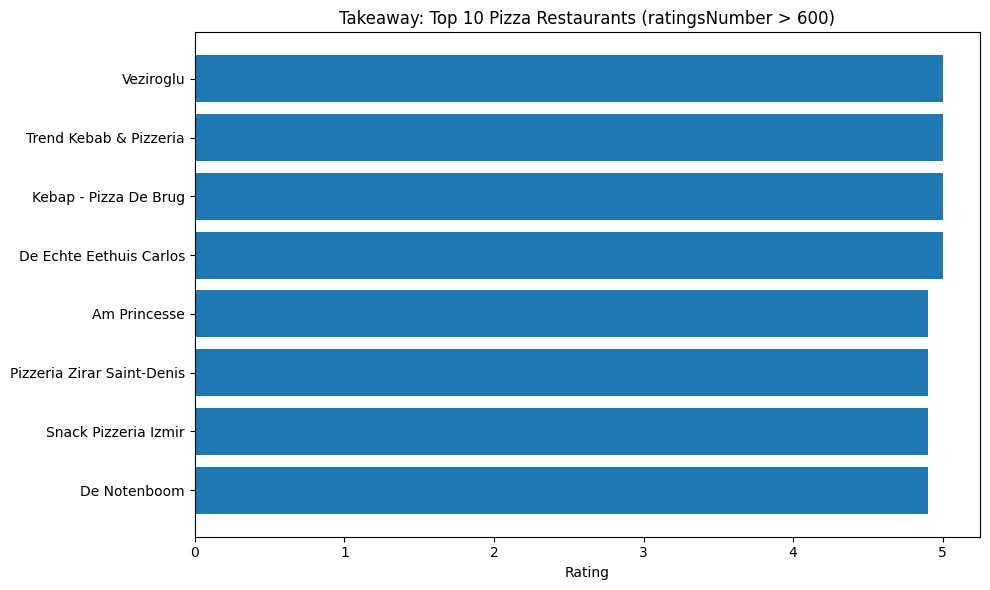

In [37]:

import matplotlib.pyplot as plt

df = top_pizza.copy()
df["label"] = df["name"].astype(str)

plt.figure(figsize=(10, 6))
plt.barh(df["label"], df["ratings"])
plt.title("Takeaway: Top 10 Pizza Restaurants (ratingsNumber > 600)")
plt.xlabel("Rating")
plt.gca().invert_yaxis()  # highest on top
plt.tight_layout()
plt.show()



# Map locations offering kapsalons and their average price

In [38]:

kapsalon_sql = """
SELECT
  r.name AS name,
  CAST(r.latitude AS REAL)  AS latitude,
  CAST(r.longitude AS REAL) AS longitude,
  r.address AS address,
  ROUND(AVG(CAST(mi.price AS REAL)), 2) AS avg_price
FROM ta.restaurants r
JOIN ta.menuItems mi
  ON mi.primarySlug = r.primarySlug
WHERE mi.name IS NOT NULL
  AND LOWER(mi.name) LIKE '%kapsalon%'
  AND mi.price IS NOT NULL
  AND TRIM(mi.price) <> ''
  AND CAST(mi.price AS REAL) > 0
  AND r.latitude IS NOT NULL
  AND r.longitude IS NOT NULL
GROUP BY r.primarySlug, r.name, r.latitude, r.longitude, r.address;
"""

kapsalon = q(conn, kapsalon_sql)
kapsalon


df_map = q(conn, sql_kapsalon_locations)
df_map.head()


,location_id,city,postalCode,latitude,longitude,avg_kapsalon_price,n_items
0,1438,Meerle,2328,51.496385,4.776083,19.17,9
1,1456,Meerle,2328,51.474327,4.804244,19.17,9
2,2048,Meerle,2328,51.491828,4.765922,19.17,9
3,762,Zwalm,9636,50.885985,3.685536,18.92,12
4,83,Meer,2321,51.442886,4.736653,18.21,19


In [39]:
import folium
from branca.colormap import linear
from folium.plugins import MarkerCluster
from pathlib import Path
import webbrowser

df = kapsalon.dropna(subset=["latitude", "longitude", "avg_price"]).copy()

m = folium.Map(location=[50.8503, 4.3517], zoom_start=8)

if not df.empty:
    vmin = float(df["avg_price"].min())
    vmax = float(df["avg_price"].max())

    colormap = linear.Reds_09.scale(vmin, vmax)
    colormap.caption = "Average kapsalon price (€)"
    colormap.add_to(m)

    cluster = MarkerCluster().add_to(m)

    for _, row in df.iterrows():
        popup = (
            f"Name: {row['name']}<br>"
            f"Avg kapsalon price: €{row['avg_price']}<br>"
            f"Address: {row.get('address','')}"
        )

        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=6,
            color=colormap(row["avg_price"]),
            fill=True,
            fill_color=colormap(row["avg_price"]),
            fill_opacity=0.8,
            popup=folium.Popup(popup, max_width=300),
        ).add_to(cluster)

out_path = Path(r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\takeaway_kapsalon_restaurants_map.html").resolve()
m.save(str(out_path))
webbrowser.open(str(out_path))
print("Saved to:", out_path)


Saved to: C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\takeaway_kapsalon_restaurants_map.html


# Q5 Which restaurants have the best price-to-rating ratio

In [40]:
ratio_sql = """
SELECT
  r.name AS name,
  ROUND(
    AVG(CASE
          WHEN mi.price IS NOT NULL
           AND TRIM(mi.price) <> ''
           AND CAST(mi.price AS REAL) > 1
          THEN CAST(mi.price AS REAL)
        END) / CAST(r.ratings AS REAL),
    3
  ) AS price_to_ratio
FROM ta.restaurants r
JOIN ta.menuItems mi
  ON mi.primarySlug = r.primarySlug
WHERE r.ratings IS NOT NULL
  AND CAST(r.ratings AS REAL) > 0
  AND r.ratingsNumber IS NOT NULL
  AND CAST(r.ratingsNumber AS INT) > 500
GROUP BY r.primarySlug, r.name, r.ratings
HAVING AVG(CASE
            WHEN mi.price IS NOT NULL
             AND TRIM(mi.price) <> ''
             AND CAST(mi.price AS REAL) > 1
            THEN CAST(mi.price AS REAL)
          END) IS NOT NULL
ORDER BY price_to_ratio ASC
LIMIT 10;
"""

ratio = q(conn, ratio_sql)
ratio


,name,price_to_ratio
0,Frituur Amigos,0.659
1,Frituur Permeke,0.727
2,Frituur Roma,0.739
3,Frituur Marcel,0.783
4,La Friterie Red,0.790
5,'t Gouden Frietje,0.854
6,'t Friet-Uurke,0.895
7,Frituur Milo,0.911
8,Antoinetta's Snacks Frituur,0.920
9,Frituur Kattekwaad,0.929


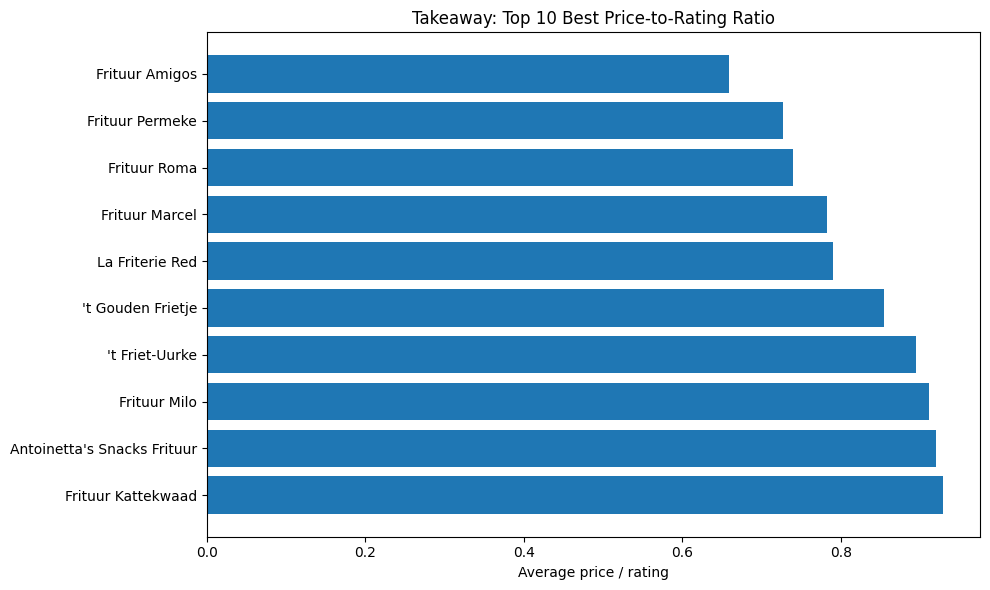

In [42]:
import matplotlib.pyplot as plt

df = ratio.copy().sort_values("price_to_ratio", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(df["name"], df["price_to_ratio"])
plt.title("Takeaway: Top 10 Best Price-to-Rating Ratio")
plt.xlabel("Average price / rating")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Q 6 . Where are the delivery ‘dead zones

In [46]:
dead_zone_sql = """
SELECT
  l.postalCode,
  COUNT(DISTINCT ltr.restaurant_id) AS num_restaurants
FROM ta.locations_to_restaurants ltr
JOIN ta.locations l
  ON ltr.location_id = l.ID
WHERE l.postalCode IS NOT NULL
GROUP BY l.postalCode
HAVING COUNT(DISTINCT ltr.restaurant_id) < 10
ORDER BY num_restaurants ASC;
"""

dead_zone = q(conn, dead_zone_sql)
dead_zone


,postalCode,num_restaurants
0,8640,1
1,8647,1
2,8972,1
3,8978,1
4,9988,1
...,...,...
74,9880,9
75,9910,9
76,9932,9
77,9968,9


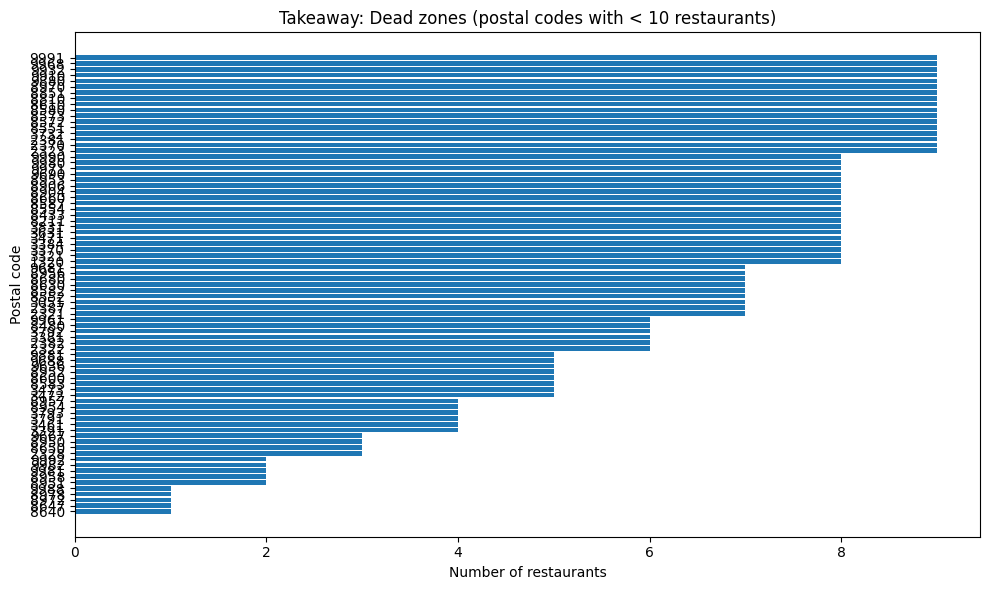

In [47]:
import matplotlib.pyplot as plt

df = dead_zone.copy().sort_values("num_restaurants", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(df["postalCode"].astype(str), df["num_restaurants"])
plt.title("Takeaway: Dead zones (postal codes with < 10 restaurants)")
plt.xlabel("Number of restaurants")
plt.ylabel("Postal code")
plt.tight_layout()
plt.show()


# Q7. How does the availability of vegetarian and vegan dishes vary by area

In [55]:
import pandas as pd
import folium
from folium.plugins import HeatMap
import webbrowser
from pathlib import Path

veggie_loc_sql = """
WITH veg_restaurants AS (
  SELECT DISTINCT restaurant_id
  FROM ta.categories
  WHERE name IS NOT NULL
    AND (
      -- English
      LOWER(name) LIKE '%vegetarian%'
      OR LOWER(name) LIKE '%vegan%'
      OR LOWER(name) LIKE '%veggie%'
      OR LOWER(name) LIKE '%plant based%'
      OR LOWER(name) LIKE '%plant-based%'
      OR LOWER(name) LIKE '%plant%'

      -- French
      OR LOWER(name) LIKE '%vegetarien%'
      OR LOWER(name) LIKE '%végétarien%'
      OR LOWER(name) LIKE '%vege%'
      OR LOWER(name) LIKE '%végé%'
      OR LOWER(name) LIKE '%vegetal%'
      OR LOWER(name) LIKE '%végétal%'
      OR LOWER(name) LIKE '%vegetal%'
      OR LOWER(name) LIKE '%végétal%'
      OR LOWER(name) LIKE '%plantes%'
      OR LOWER(name) LIKE '%vegetale%'
      OR LOWER(name) LIKE '%végétale%'
      OR LOWER(name) LIKE '%vegetale%'
      OR LOWER(name) LIKE '%végétale%'

      -- Flemish/Dutch
      OR LOWER(name) LIKE '%vegetarisch%'
      OR LOWER(name) LIKE '%vegetari%'
      OR LOWER(name) LIKE '%plantaardig%'
      OR LOWER(name) LIKE '%planten%'
      OR LOWER(name) LIKE '%plantaardig%'
    )
)
SELECT
  l.ID AS location_id,
  l.city,
  l.postalCode,
  CAST(l.latitude AS REAL)  AS latitude,
  CAST(l.longitude AS REAL) AS longitude,
  COUNT(DISTINCT lr.restaurant_id) AS veg_restaurant_count
FROM ta.locations l
JOIN ta.locations_to_restaurants lr
  ON lr.location_id = l.ID
JOIN veg_restaurants v
  ON v.restaurant_id = lr.restaurant_id
WHERE l.latitude IS NOT NULL AND l.longitude IS NOT NULL
GROUP BY l.ID, l.city, l.postalCode, l.latitude, l.longitude
ORDER BY veg_restaurant_count DESC;
"""

df_veg_loc = q(conn, veggie_loc_sql)
df_veg_loc.head(10)


,location_id,city,postalCode,latitude,longitude,veg_restaurant_count
0,2161,Antwerp,2018,51.193996,4.410126,104
1,2175,Antwerp,2140,51.210885,4.433730,104
2,2178,Antwerp,2140,51.213178,4.451508,104
3,247,Antwerp,2140,51.216422,4.434121,103
4,526,Antwerp,2140,51.209830,4.452842,103
5,731,Antwerp,2140,51.220805,4.441732,103
6,1096,Antwerp,2600,51.197080,4.411548,102
7,2168,Antwerp,2018,51.214206,4.425389,102
8,2174,Antwerp,2140,51.215296,4.441809,102
9,154,Antwerp,2600,51.199085,4.424140,101


In [56]:
import folium
import webbrowser
from pathlib import Path

m2 = folium.Map(location=[50.8503, 4.3517], zoom_start=8)

top = df_veg_loc.sort_values("veg_restaurant_count", ascending=False).head(50).copy()

for _, row in top.iterrows():
    popup = (
        f"City: {row['city']}<br>"
        f"Postal code: {row['postalCode']}<br>"
        f"Veg restaurants: {int(row['veg_restaurant_count'])}"
    )

    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=max(4, min(14, 3 + (row["veg_restaurant_count"] ** 0.5))),
        color="green",
        fill=True,
        fill_color="green",
        fill_opacity=0.7,
        popup=folium.Popup(popup, max_width=300),
    ).add_to(m2)

out_path2 = Path(r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\takeaway_veg_top50_locations.html").resolve()
m2.save(str(out_path2))
webbrowser.open(str(out_path2))
print("Saved to:", out_path2)


Saved to: C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\takeaway_veg_top50_locations.html


# The World Hummus Order (WHO); top 3 hummus serving restaurants.

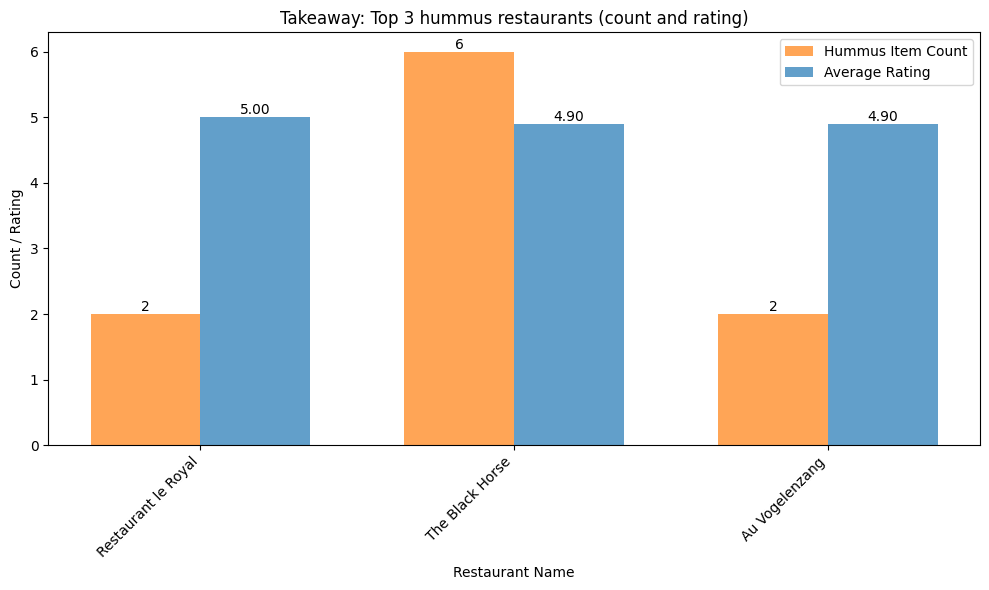

,restaurant_name,avg_rating,hummus_item_count
0,Restaurant le Royal,5.0,2
1,The Black Horse,4.9,6
2,Au Vogelenzang,4.9,2


In [61]:
import matplotlib.pyplot as plt

takeaway_hummus_sql = """
SELECT
  r.name AS restaurant_name,
  CAST(r.ratings AS REAL) AS avg_rating,
  COUNT(*) AS hummus_item_count
FROM ta.restaurants r
JOIN ta.menuItems mi
  ON r.primarySlug = mi.primarySlug
WHERE mi.name IS NOT NULL
  AND (
    LOWER(mi.name) LIKE '%hummus%'
    OR LOWER(mi.name) LIKE '%houmous%'
    OR LOWER(mi.name) LIKE '%homous%'
    OR LOWER(mi.name) LIKE '%houmos%'
  )
  AND r.ratingsNumber IS NOT NULL
  AND CAST(r.ratingsNumber AS INT) > 100
  AND r.ratings IS NOT NULL
GROUP BY r.primarySlug, r.name, r.ratings
ORDER BY avg_rating DESC, hummus_item_count DESC
LIMIT 3;
"""

df = q(conn, takeaway_hummus_sql)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = range(len(df))

bars1 = ax.bar(
    index,
    df["hummus_item_count"],
    bar_width,
    label="Hummus Item Count",
    color="tab:orange",
    alpha=0.7
)

bars2 = ax.bar(
    [i + bar_width for i in index],
    df["avg_rating"],
    bar_width,
    label="Average Rating",
    color="tab:blue",
    alpha=0.7
)

ax.set_xlabel("Restaurant Name")
ax.set_ylabel("Count / Rating")
ax.set_title("Takeaway: Top 3 hummus restaurants (count and rating)")
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(df["restaurant_name"], rotation=45, ha="right")
ax.legend()

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f"{int(yval)}", ha="center", va="bottom")

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

df


# Create a Venn diagram comparing restaurant distributions across all platforms

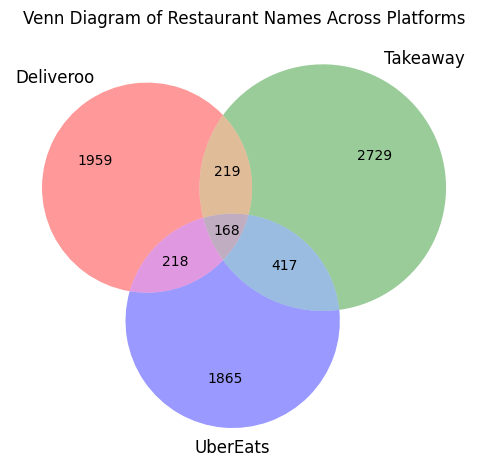

In [23]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Distinct restaurant names from each platform (your setup: main=Deliveroo, ta=Takeaway, ue=UberEats)
ids1 = set(q(conn, "SELECT DISTINCT name  FROM restaurants     WHERE name  IS NOT NULL;")["name"])
ids2 = set(q(conn, "SELECT DISTINCT name  FROM ta.restaurants  WHERE name  IS NOT NULL;")["name"])
ids3 = set(q(conn, "SELECT DISTINCT title FROM ue.restaurants  WHERE title IS NOT NULL;")["title"])

only_in_1 = ids1 - ids2 - ids3
only_in_2 = ids2 - ids1 - ids3
only_in_3 = ids3 - ids1 - ids2

in_1_and_2 = (ids1 & ids2) - ids3
in_1_and_3 = (ids1 & ids3) - ids2
in_2_and_3 = (ids2 & ids3) - ids1

in_all = ids1 & ids2 & ids3

venn3(
    subsets=(
        len(only_in_1),
        len(only_in_2),
        len(in_1_and_2),
        len(only_in_3),
        len(in_1_and_3),
        len(in_2_and_3),
        len(in_all),
    ),
    set_labels=("Deliveroo", "Takeaway", "UberEats"),
)

plt.title("Venn Diagram of Restaurant Names Across Platforms")
plt.tight_layout()
plt.show()
